In [104]:
library(tidyverse)
library(RSQLite)
library(scales)
library(slider)
library(furrr)
library(xts)
library(gplots)


tidy_finance <- dbConnect(
  SQLite(),
  "data/tidy_finance_r.sqlite",
  extended_types = TRUE
)
# Read tables from the database
crsp_monthly <- tbl(tidy_finance, "crsp_monthly") %>%
  collect()

compustat <- tbl(tidy_finance, "compustat") %>%
  collect()

cpi_monthly <- tbl(tidy_finance, "cpi_monthly") %>%
  collect()

factors_ff3_daily <- tbl(tidy_finance, "factors_ff3_daily") %>%
  collect()

factors_ff3_monthly <- tbl(tidy_finance, "factors_ff3_monthly") %>%
  collect()

factors_ff5_monthly <- tbl(tidy_finance, "factors_ff5_monthly") %>%
  collect()

factors_q_monthly <- tbl(tidy_finance, "factors_q_monthly") %>%
  collect()

industries_ff_monthly <- tbl(tidy_finance, "industries_ff_monthly") %>%
  collect()

macro_predictors <- tbl(tidy_finance, "macro_predictors") %>%
  collect()

permnos <- read_csv("./data/all_permnos.txt",
                    col_names = FALSE) %>% pull()
set.seed(7244)
mypermnos = permnos %>% base::sample(100)



# Filter the crsp_monthly dataset to include only data from Jan 2000 to Dec 2023
filtered_crsp_monthly <- crsp_monthly %>%
  filter(month >= as.Date("1999-12-31") & month <= as.Date("2023-11-21"))

print(dim(filtered_crsp_monthly))


sampled_crsp_monthly <- filtered_crsp_monthly %>%
  filter(permno %in% mypermnos) %>%select(-c('month',"ret_excess", "industry",'shrout','altprc','exchcd','siccd','mktcap','mktcap_lag','exchange','gvkey'))  # Remove the columns "mkt_excess" and "industry"


# Pivot the data to wide format
sampled_crsp_wide <- sampled_crsp_monthly %>%
  pivot_wider(
    names_from = permno,
    values_from = ret
  )

# Check the dimensions of the wide format data
print(dim(sampled_crsp_wide))


# Remove the "month" column from the dataframe
sampled_crsp_xts <- sampled_crsp_wide %>%
  select(-date)

# Convert the remaining columns to an xts object
sampled_crsp_xts <- xts(as.matrix(sampled_crsp_xts), order.by = sampled_crsp_wide$date)

# Rename the columns with mypermnos
colnames(sampled_crsp_xts) <- colnames(sampled_crsp_wide)[-1]  # Exclude the "month" column




Rows: 489 Columns: 1
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (1): X1

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 1238615      14
[1] 287 101
              X11481
2000-01-31 -0.150838
2000-02-29  0.355263
2000-03-31 -0.024272
2000-04-28 -0.398010
2000-05-31 -0.190083
2000-06-30 -0.168367
2000-07-31  0.079755
2000-08-31 -0.170455
2000-09-29 -0.219178
2000-10-31 -0.438596
       ...          
2023-02-28 -0.088143
2023-03-31 -0.241082
2023-04-28  0.232752
2023-05-31  0.225092
2023-06-30  0.265060
2023-07-31  0.228571
2023-08-31 -0.460594
2023-09-29 -0.408383
2023-10-31 -0.383603
2023-11-30 -0.353038


In [105]:
# Find the indices (row numbers) where the value for asset 11481 is missing
missing_indices <- which(is.na(sampled_crsp_xts[, "11481"]))

# Check the dates corresponding to the missing values for asset 11481
missing_dates <- index(sampled_crsp_xts)[missing_indices]

# Print the missing dates
print("Dates corresponding to missing values for asset 11481:")
print(missing_dates)


[1] "Dates corresponding to missing values for asset 11481:"
Date of length 0


# 1.Correlation-Based Measures
Assess interdependence between assets.

# Pearson's Correation

diversification, hedging, or a combination of both(correlationship is close to 0 or negative value)

examine correlation scatter plot over time – a risk heatmap
problems: not applicable to non-linear, non-monotone transformations

[1] "Pearson<U+2019>s Correlation:"
            10032      10138       10501      10696        10866        10932
10032  1.00000000 0.44493761  0.39892428 0.31339898  0.264008648  0.281972678
10138  0.44493761 1.00000000  0.46646127 0.44342935  0.400092175  0.454949224
10501  0.39892428 0.46646127  1.00000000 0.34311585  0.351317494  0.354959034
10696  0.31339898 0.44342935  0.34311585 1.00000000  0.278792137  0.332946433
10866  0.26400865 0.40009217  0.35131749 0.27879214  1.000000000  0.477835210
10932  0.28197268 0.45494922  0.35495903 0.33294643  0.477835210  1.000000000
11018  0.22467697 0.34095593  0.34003006 0.24216321  0.286361413  0.452698065
11144  0.13793493 0.21123597  0.20210273 0.14905239  0.164119451  0.130150015
11154  0.28583149 0.29611938  0.23824665 0.22236916  0.372810862  0.187424021
11308  0.11589469 0.33206355  0.15821715 0.38738630  0.187018139  0.193444323
11368  0.12794724 0.18593545  0.16881831 0.07920499  0.146591709  0.137008139
11369  0.31278617 0.46284544

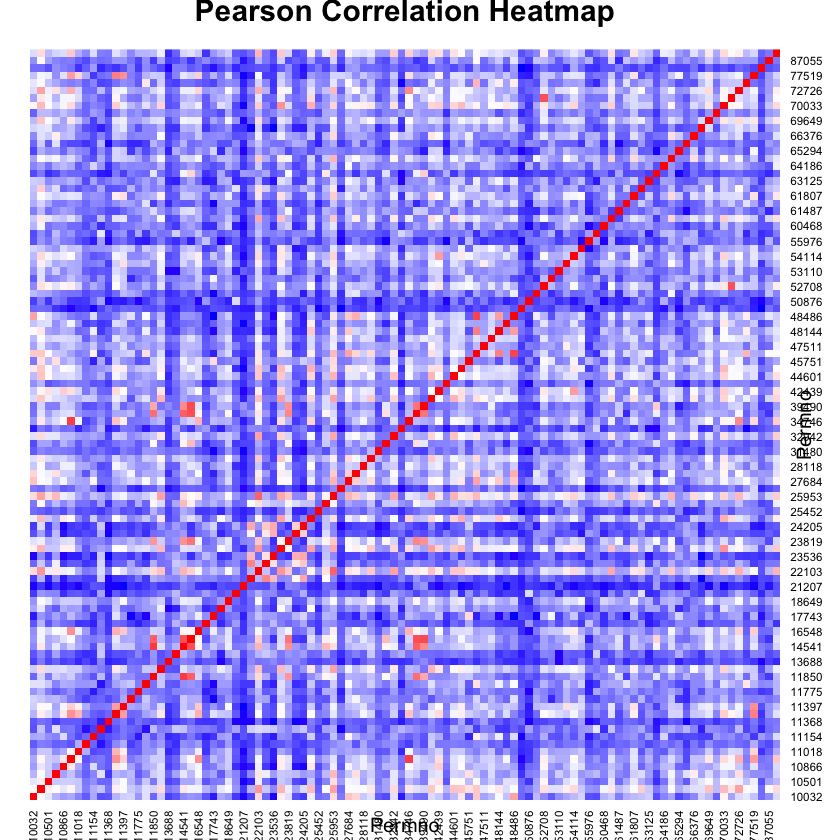

In [106]:
# Calculate Pearson’s Correlation
pearson_corr <- cor(sampled_crsp_xts, method = "pearson")
# Load required library
library(gplots) 

# Set up the plot
heatmap(
  pearson_corr, 
  scale = "none",  # Don't scale rows and columns
  Rowv = NA,       # Don't cluster rows
  Colv = NA,       # Don't cluster columns
  col = colorRampPalette(c("blue", "white", "red"))(100),  # Color palette with 200 colors
  margins = c(2, 2),  # Set larger margins
  main = "Pearson Correlation Heatmap",  # Add a title
  xlab = "Permno",  # Label for x-axis
  ylab = "Permno"   # Label for y-axis
)


# Print the results
print("Pearson’s Correlation:")
print(pearson_corr)



# Kendall’s Tau

[1] "Kendall<U+2019>s Tau:"
           10032      10138        10501      10696        10866        10932
10032 1.00000000 0.27214249  0.270729271 0.22433664  0.128530007  0.234813967
10138 0.27214249 1.00000000  0.319363563 0.29168393  0.214882678  0.301381545
10501 0.27072927 0.31936356  1.000000000 0.21444409  0.214639020  0.265563705
10696 0.22433664 0.29168393  0.214444092 1.00000000  0.151580127  0.195877293
10866 0.12853001 0.21488268  0.214639020 0.15158013  1.000000000  0.242172462
10932 0.23481397 0.30138155  0.265563705 0.19587729  0.242172462  1.000000000
11018 0.17158660 0.24078654  0.232209647 0.16052436  0.185036732  0.359401079
11144 0.15375431 0.17193192  0.164865556 0.10969919  0.119592100  0.164719356
11154 0.30706254 0.29176058  0.236790487 0.25155639  0.190835882  0.185329126
11308 0.07887235 0.18793402  0.082429765 0.22190005  0.071708779  0.071854974
11368 0.13164884 0.14928973  0.125264979 0.04388295  0.086961819  0.134377817
11369 0.24188007 0.30961721  0.28637

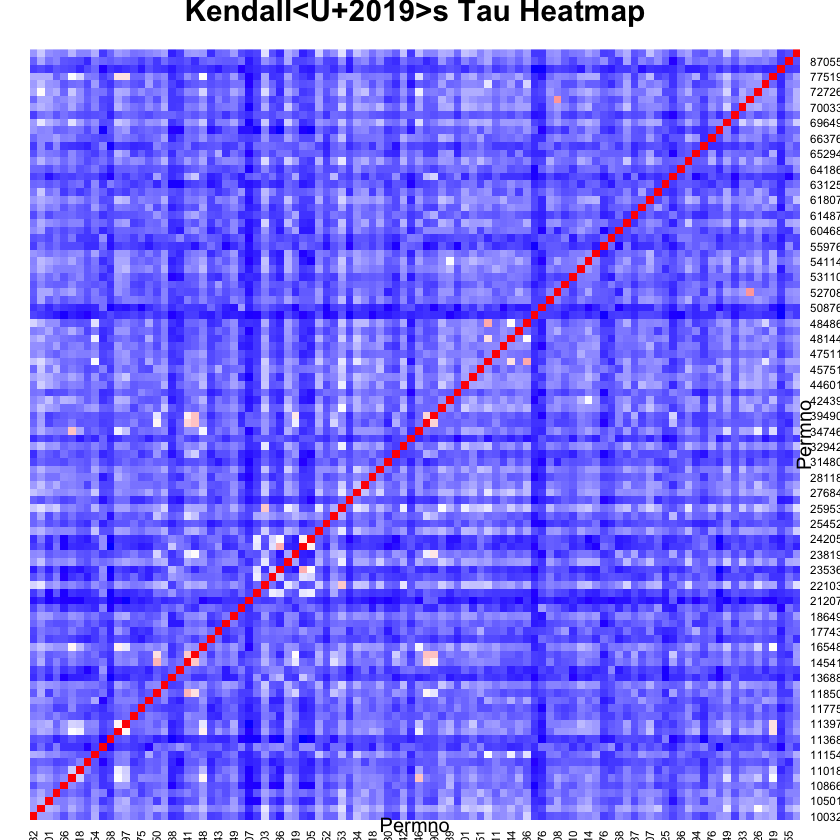

In [107]:
# Calculate Kendall’s Tau
kendall_tau <- cor(sampled_crsp_xts, method = "kendall")


print("Kendall’s Tau:")
print(kendall_tau)

# Visualize Kendall’s Tau
heatmap(
  kendall_tau, 
  scale = "none",
  Rowv = NA,
  Colv = NA,
  col = colorRampPalette(c("blue", "white", "red"))(100), 
  margins = c(1, 1),
  main = "Kendall’s Tau Heatmap",
  xlab = "Permno",
  ylab = "Permno"
)

# Spearman’s Rho

[1] "Spearman<U+2019>s Rho:"
           10032      10138        10501      10696        10866       10932
10032 1.00000000 0.38296358  0.392549016 0.32305296  0.184465941  0.34034005
10138 0.38296358 1.00000000  0.463298896 0.41968804  0.306153704  0.42733638
10501 0.39254902 0.46329890  1.000000000 0.31364012  0.310018741  0.38785655
10696 0.32305296 0.41968804  0.313640120 1.00000000  0.222899052  0.28205788
10866 0.18446594 0.30615370  0.310018741 0.22289905  1.000000000  0.35083971
10932 0.34034005 0.42733638  0.387856554 0.28205788  0.350839709  1.00000000
11018 0.25311709 0.35278039  0.348449613 0.23901533  0.266012477  0.49985564
11144 0.23018507 0.26001095  0.248240707 0.16673173  0.179692858  0.23903801
11154 0.42569022 0.42078988  0.342135550 0.35643223  0.274712873  0.26932014
11308 0.11751460 0.27288616  0.122888291 0.31914935  0.107136258  0.10407022
11368 0.19530774 0.22018530  0.189935065 0.06764932  0.127741669  0.20122104
11369 0.35043564 0.44093305  0.427424202 0.2991

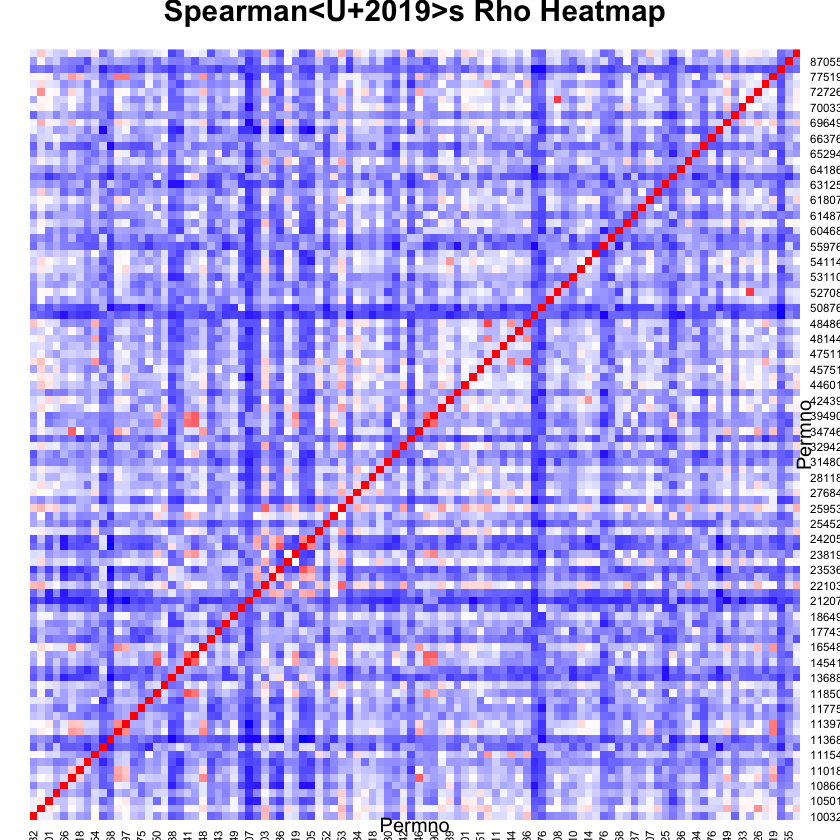

In [108]:
# Calculate Spearman’s Rho
spearman_rho <- cor(sampled_crsp_xts, method = "spearman")

print("Spearman’s Rho:")
print(spearman_rho)

# Visualize Spearman’s Rho
heatmap(
  spearman_rho, 
  scale = "none",
  Rowv = NA,
  Colv = NA,
  col = colorRampPalette(c("blue", "white", "red"))(100), 
  margins = c(1, 1),
  main = "Spearman’s Rho Heatmap",
  xlab = "Permno",
  ylab = "Permno"
)

# Tail Area Dependence
Tail Area Dependence: filter asset by some threshold on correlation
measure joint probability in tails, joint extreme risks
can be used for either upper or lower tail dependence


In [138]:
# Define a function to calculate Tail Area Dependence (TAD)
calculate_TAD <- function(x) {
  # Define the threshold for considering tails
  threshold <- quantile(x, 0.99)  # Considering the upper 1% tail
  
  # Filter observations exceeding the threshold
  tail_observations <- x[x > threshold]
  
  # Calculate the proportion of observations in tails
  TAD <- length(tail_observations) / length(x)
  
  return(TAD)
}

# Apply the function to each column of sampled_crsp_xts
TAD_values <- sapply(sampled_crsp_xts, calculate_TAD)

# Create a data frame with permno names and corresponding TAD values
TAD_df <- data.frame(permno = colnames(sampled_crsp_xts), TAD = TAD_values)

# Filter to have the permno name
print(TAD_df)


      permno        TAD
10032  10032 0.01045296
10138  10138 0.01045296
10501  10501 0.01045296
10696  10696 0.01045296
10866  10866 0.01045296
10932  10932 0.01045296
11018  11018 0.01045296
11144  11144 0.01045296
11154  11154 0.01045296
11308  11308 0.01045296
11368  11368 0.01045296
11369  11369 0.01045296
11397  11397 0.01045296
11481  11481 0.01045296
11775  11775 0.01045296
11752  11752 0.01045296
11850  11850 0.01045296
12036  12036 0.01045296
13688  13688 0.01045296
13901  13901 0.01045296
14541  14541 0.01045296
15069  15069 0.01045296
16548  16548 0.01045296
16678  16678 0.01045296
17743  17743 0.01045296
18075  18075 0.01045296
18649  18649 0.01045296
20482  20482 0.01045296
21207  21207 0.01045296
21776  21776 0.01045296
22103  22103 0.01045296
22517  22517 0.01045296
23536  23536 0.01045296
23579  23579 0.01045296
23819  23819 0.01045296
23931  23931 0.01045296
24205  24205 0.01045296
24272  24272 0.01045296
25452  25452 0.01045296
25590  25590 0.01045296
25953  25953 0.0

# Assets selection results

In [141]:
# Filter pairs based on correlation thresholds
high_corr_pairs <- which(pearson_corr < 0.1 | kendall_tau < 0.1 | spearman_rho < 0.1)

# Select the corresponding permnos for the high correlation pairs
selected_permnos <- colnames(sampled_crsp_xts)[high_corr_pairs]

# Print selected permnos
print(selected_permnos)

   [1] "11308" "13688" "13901" "16678" "17743" "20482" "21207" "21776" "23536"
  [10] "23931" "24205" "32803" "32870" "50876" "55976" "65875" "69796" NA     
  [19] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [28] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [37] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [46] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [55] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [64] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [73] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [82] NA      NA      NA      NA      NA      NA      NA      NA      NA     
  [91] NA      NA      NA      NA      NA      NA      NA      NA      NA     
 [100] NA      NA      NA      NA      NA      NA      NA      NA      NA     
 [109] NA      NA      NA      NA      NA      NA   

# 2.Copula-Based Measures


# Copula: 
1. a joint distribution function with uniform marginals. 
e.g. in Bivariant Gaussian and Gumble

2. concordance measure: scale invariant, capture nonlinear dependence 
(depend on the Copula and not the marginal distributions)

In [149]:
# Load required libraries
library(copula)

# Step 1: Define the correlation coefficient
cor_coef <- 0.77  # This can be any correlation coefficient you want to use

# Step 2: Create a Gaussian Copula with the specified correlation coefficient
my_cop <- normalCopula(cor_coef, dim = ncol(sampled_crsp_xts), dispstr = "ex")

# Step 3: Define the marginal distributions
# Here, assuming you want Gaussian marginals
margins <- c("norm", "norm")  # Gaussian distribution
param_margins <- list(list(mean = 0, sd = 1), list(mean = 0, sd = 1))  # Parameters for Gaussian distribution

# Step 4: Create a multivariate distribution with the Copula and marginal distributions
my_mvd <- mvdc(copula = my_cop, margins = margins, paramMargins = param_margins)

# Step 5: Generate random samples from the multivariate distribution
# You can use rMvdc() function to generate random samples
# For example, to generate 1000 random samples:
num_samples <- 1000
random_samples <- rMvdc(my_mvd, n = num_samples)

# Step 6: Analyze or use the random samples as needed
# For example, you can analyze the tail dependence coefficients or use the samples for further analysis

# Note: Adjust parameters and steps as needed for your specific use case


ERROR: Error in validObject(.Object): invalid class "mvdc" object: 'dimension' does not match margins' length


# Gerber Statistics 
It is copula on Kendall’s Tau

In [151]:
library(Kendall)
library(Rcpp)
library(Matrix)

# Step 1: Calculate Kendall's Tau correlation matrix
kendall_matrix <- cor(sampled_crsp_xts, method = "kendall")

# Step 2: Define a function to calculate Gerber Statistics
gerber_statistics <- function(cor_matrix, threshold) {
  # Convert correlation matrix to a matrix object
  cor_matrix <- as.matrix(cor_matrix)
  
  # Apply the Gerber Statistics calculation
  gerber_matrix <- ifelse(cor_matrix >= threshold, 1, 0)
  
  # Convert the matrix to a sparse matrix for efficient computation
  gerber_sparse <- as(gerber_matrix, "sparseMatrix")
  
  # Sum the values in the upper triangle of the matrix
  gerber_sum <- sum(gerber_sparse@x)
  
  # Calculate Gerber Statistics
  n <- nrow(cor_matrix)
  gerber_stats <- (2 * gerber_sum - n) / (n * (n - 1))
  
  return(gerber_stats)
}

# Step 3: Calculate Gerber Statistics and filter permno names
gerber_threshold <- 0.5  # Define your Gerber Statistics threshold here

gerber_stats <- gerber_statistics(kendall_matrix, gerber_threshold)

# Filter permno names based on Gerber Statistics threshold
selected_permnos <- names(which(gerber_stats > 0))

# Print selected permno names
print(selected_permnos)

# Further steps if needed...



Attaching package: 'Kendall'


The following object is masked from 'package:QRM':

    Kendall




NULL


# 3.Portfolio Concentration Measures

# Effective Number of Constituents (ENC)
Weight-based measure of portfolio concentration.

# GLR Measure
Ratio of portfolio variance to weighted average of constituent assets' variances.

# 4.Factor-Based Measures

# Effective Number of Bets (ENB)
Decomposes portfolio return into uncorrelated factors using PCA eigenvector decomposition.

# Minimum Torsion Bets (MTB)
Selects a unique portfolio minimizing squared tracking error with uncorrelated factors.

# Risk Premia Principal Component Analysis (RP-PCA)
Incorporates expected return into PCA, accounting for cross-sectional pricing errors.